Rocketシミュレータのノートを作ってみる

サブクラスのファイルをローカルに持ってみた
（グラフの日本語フォントが問題だった。これで一応、結果が表示されるようになった）

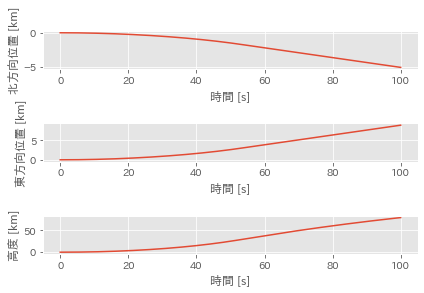

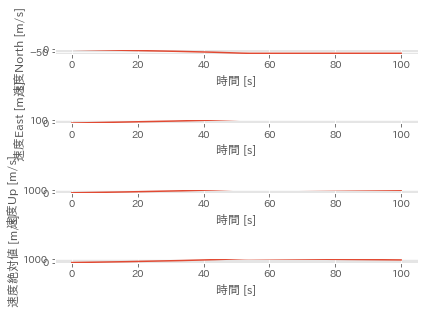

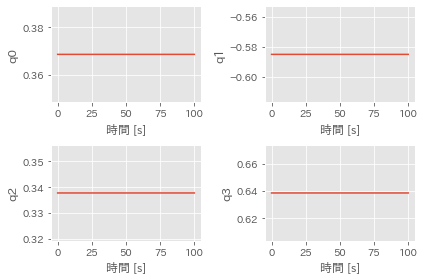

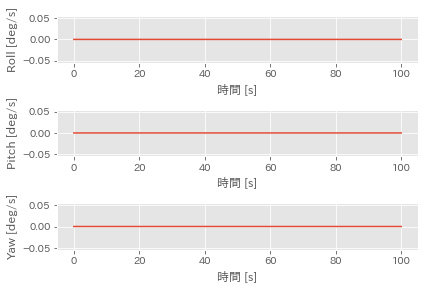

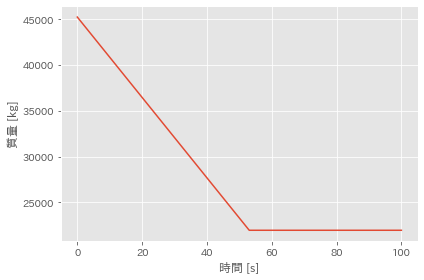

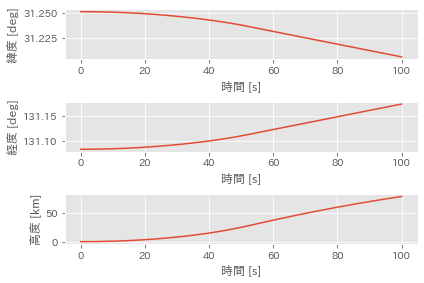

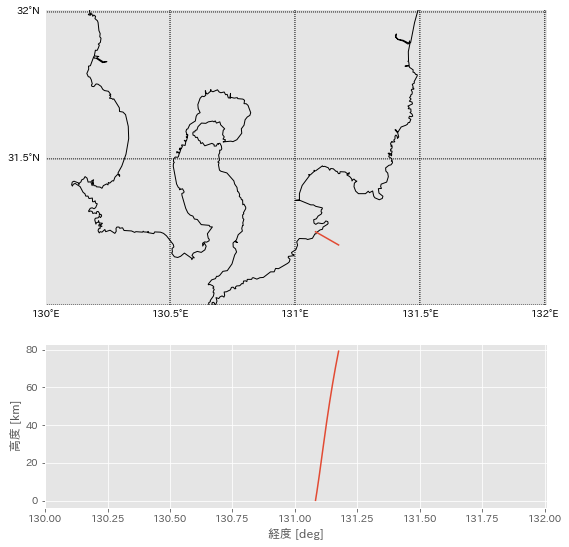

In [2]:
%matplotlib inline
"""
Rocket simulator

Copyright (c) 2016 Kenji Nakakuki
Released under the MIT license
"""

import numpy as np
from numpy import sin, cos, arcsin, pi
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import interp1d
from mpl_toolkits.basemap import Basemap
import quaternion as qt
import environment as env
import coordconv as cc

# Matplotlibの設定
plt.style.use('ggplot')
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.family'] = 'IPAexGothic'
mpl.rcParams['axes.grid'] = True

# 一般定数設定
D2R = pi / 180.0
R2D = 180.0 / pi

# Rocketの諸元設定(M-3S)
rocket_settings = {
    'm0': 45247.4,  # [kg] 初期質量
    'Isp': 266,  # [s] Specific Impulse
    'g0': 9.80665,  # [m/s^2] 重力定数
    'FT': 1147000,  # [N] 推力（一定）
    'Tend': 53,  # [s] ロケット燃焼終了時間
    'Area': 1.41 ** 2 / 4 * pi,  # [m^2] 基準面積
    'CLa': 3.5,  # [-] 揚力傾斜
    'length_GCM': [-9.76, 0, 0],  # [m] R/Mジンバル・レバーアーム長
    'length_A': [-1.0, 0, 0],  # [m] 機体空力中心・レバーアーム長
    'Ijj': [188106.0, 188106.0, 1839.0],  # [kg*m^2] 慣性能率
    'IXXdot': 0,  # [kg*m^2/s] 慣性能率変化率 X軸
    'IYYdot': 0,  # [kg*m^2/s] 慣性能率変化率 Y軸
    'IZZdot': 0,  # [kg*m^2/s] 慣性能率変化率 Z軸
    'roll': 0,  # [deg] 初期ロール
    'pitch': 85.0,  # [deg] 初期ピッチ角
    'yaw': 120.0,  # [deg] 初期方位角
    'lat0': 31.251008,  # [deg] 発射地点緯度(WGS84)
    'lon0': 131.082301,  # [deg] 発射地点経度(WGS84)
    'alt0': 194,  # [m] 発射地点高度(WGS84楕円体高)
    # CD定義用のMach数とCDのテーブル
    'mach_tbl': np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1, 1.2, 1.4, 1.6,
                          1.8, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]),
    'CD_tbl': np.array([0.28, 0.28, 0.28, 0.29, 0.35, 0.64, 0.67, 0.69,
                        0.66, 0.62, 0.58, 0.55, 0.48, 0.42, 0.38, 0.355,
                        0.33])
}


class RocketSim:
    """ロケットシミュレーション用クラス

    [座標系定義]
    射点中心慣性座標系 n : 発射位置原点直交座標系(North-East-Down)
    ロケット機材座標系 b : XYZ=前方/右舷/下方

    """

    def __init__(self, **kwargs):
        """ロケットの初期値状態設定

        (1) 常微分方程式に使う状態量ベクトルの初期値 x0 の設定 (14次)
            m0 : ロケット全体の初期質量 [kg] (1x1)
            pos0: 射点中心慣性座標系における位置（North-East-Down)[m] (3x1)
            vel0: 射点中心慣性座標系における速度（North-East-Down)[m/s] (3x1)
            quat0: 機体座標系から水平座標系に変換を表すクォータニオン[-] (4x1)
            omega0: 機体座標系における機体に働く角速度[rad/s] (3x1)
        (2) ロケットの各種諸元設定
        (3) 制御入力+外乱
        (4) 質点モデル設定のフラグ
        """

        # (1) 状態量ベクトルの初期値 x0 の設定
        pos0 = [0.0, 0.0, 0.0]  # m
        vel0 = [0.0, 0.0, 0.0]  # m/s
        quat0, _ = qt.attitude(kwargs['roll'], kwargs['pitch'],
                               kwargs['yaw'])
        omega0 = [0.0, 0.0, 0.0]  # rad/s
        self.x0 = np.array([kwargs['m0'], *pos0, *vel0, *quat0, *omega0])
        # (2) ロケットの各種諸元設定
        self.isp = kwargs['Isp']
        self.g0 = kwargs['g0']
        self.rm_t_end = kwargs['Tend']
        self.cla = kwargs['CLa']
        self.area = kwargs['Area']
        self.length_gcm = kwargs['length_GCM']
        self.length_a = kwargs['length_A']
        self.ixx = kwargs['Ijj'][0]
        self.iyy = kwargs['Ijj'][1]
        self.izz = kwargs['Ijj'][2]
        self.ixxdot = kwargs['IXXdot']
        self.iyydot = kwargs['IYYdot']
        self.izzdot = kwargs['IYYdot']
        self.xr, self.yr, self.zr = \
            cc.blh2ecef(kwargs['lat0'], kwargs['lon0'], kwargs['alt0'])
        self.dcm_x2n_r = cc.dcm_x2n(kwargs['lat0'], kwargs['lon0'])
        self.mach_tbl = kwargs['mach_tbl']
        self.cd_tbl = kwargs['CD_tbl']
        # (3) u : 制御入力 + 外乱 (現時点では推力一定、制御入力と外乱はゼロ)
        #  推力[N], 推力ノズルPitchジンバル角度[rad], 推力ノズルYawジンバル角度[rad],
        #  ロール制御トルク[N*m], 水平座標系における風ベクトル(x,y,z)[m/s]
        self.u = np.array([kwargs['FT'], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        # (4) モーメントを計算せずに質点モデルにしてしまうかどうか設定
        #   制御プログラムを実装していない場合は下記パラメータを常に1にしておくこと。
        self.lumped_mass = 1

    def rocket_dynamics(self, x, t, u):
        """ロケットのダイナミクス計算関数

        引数:
            x: 状態量x (self.x0 参照)
            t: time 時刻[s]
            u: オプションパラメータ
                u[0]: Ft 推力[N]
                u[1]: deltaY ヨージンバル角[rad]
                u[2]: deltaP ピッチジンバル角[rad]
                u[3]: Tr ロール制御トルク[N*m]
                u[4]: VWHx 初期水平座標系における風ベクトル North[m/s]
                u[5]: VWHy 初期水平座標系における風ベクトル East[m/s]
                u[6]: VWHz 初期水平座標系における風ベクトル Down[m/s]
        返り値:
            dx: 状態量 x の時間微分
        """

        # 回転行列 dcm (発射位置NED --> 現在位置NED)を計算
        # 積分計算を発射位置のNED座標系で計算しているので適宜 dcm を使って修正する
        px, py, pz = cc.launch2ecef(x[1], x[2], x[3],
                                    self.xr, self.yr, self.zr)
        phi, lam, _ = cc.ecef2blh(px, py, pz)  # output: deg/deg/m
        dcm = cc.dcm_x2n(phi, lam) @ self.dcm_x2n_r.T

        # 大気と重力の計算
        # 大気
        ned_now = dcm @ np.array([x[1], x[2], x[3]])
        a, _, rho, _ = env.std_atmosphere(-ned_now[2])
        # 重力 (fgh : 水平座標系における機体にかかる重力[N])
        gvec = env.gravity(-ned_now[2], phi * D2R)
        fgh = x[0] * gvec  # NED座標

        # 推進剤の質量流量 delta_m[kg/s]
        if t < self.rm_t_end:
            thrust = u[0]
            delta_m = -thrust / self.isp / self.g0
        else:
            thrust = 0
            delta_m = 0

        # ジンバル角を考慮した機体座標系における推力 ftb[N]
        # ジンバル角度 deltay, deltap[rad]
        deltay = u[1]
        deltap = u[2]
        ftb = thrust * np.array([cos(deltay) * cos(deltap),
                                 -sin(deltay),
                                 -cos(deltay) * sin(deltap)])

        # 空気力
        # 水平座標系における風ベクトルVWH[m/s]（高度方向の分布は無いものとする）
        # 水平座標系における機体の対気速度ベクトル va[m/s]
        va = x[4:7] - u[4:7]  # 対気速度

        # 機体座標系から水平座標系への座標変換を表すクォータニオン quat (quat_B2H)
        quat = x[7:11]  # q_B2H

        # クォータニオンから方向余弦行列 cbn へ変換
        cbn = qt.rot_coord_mat(quat)

        # 機体座標系からみた速度ベクトル vab を求めて速度座標系の定義から
        # 機体座標系からみた速度座標系の基底ベクトル[xAB yAB zAB]をもとめて
        # 速度座標系から機体座標系への方向余弦行列DCM_A2Bを求めている。
        # 機体座標系における空気力 fab [N]
        if np.linalg.norm(va) == 0.0:
            xab = np.array([1, 0, 0])  # 機体座標系速度方向単位ベクトル
            # vab = np.array([0, 0, 0])
        else:
            vab = cbn.T @ va  # 機体座標系に変換(発射点NED --> 機体座標)
            xab = vab / np.linalg.norm(vab)

        yab_sintheta = np.cross(xab, np.array([1, 0, 0]))
        sintheta = np.linalg.norm(yab_sintheta)
        if sintheta < 1.e-10:
            yab = np.array([0, 1, 0])
        else:
            tmp = yab_sintheta / sintheta
            yab = tmp / np.linalg.norm(tmp)

        theta = arcsin(sintheta)
        zab = np.cross(xab, yab)

        # 速度座標系からみた空気力 faa [N]
        f_cd = interp1d(self.mach_tbl, self.cd_tbl, kind='linear', copy=False,
                        fill_value='extrapolate')
        cd = f_cd(np.linalg.norm(va) / a)
        faa = -0.5 * rho * (np.linalg.norm(va) ** 2) * self.area * \
            np.array([cd, 0, self.cla * theta])

        dcm_a2b = np.c_[xab, yab, zab].T  # 転置に注意
        fab = dcm_a2b @ faa  # ＠は行列積 (Python 3.5以上)

        # モーメント(mom_t: 推力によるもの[Nm], mom_a:空気力によるもの[Nm])
        if self.lumped_mass == 1:
            moment = [0., 0., 0.]
        else:
            # mom_t = -np.cross(ftb, self.length_gcm)
            # mom_a = -np.cross(fab, self.length_a)
            # moment = mom_t + mom_a + [u[3], 0, 0]
            raise ValueError('Controller is not yet implemented.')

        # 速度運動方程式
        ftah = cbn @ (ftb + fab)
        delta_v = (1 / x[0]) * (ftah + fgh)  # 発射点NED座標

        # 姿勢の運動方程式
        delta_quat = qt.deltaquat(quat, x[11:14])

        # 角速度の運動方程式
        delta_omega = [1 / self.ixx * (moment[0] - self.ixxdot * x[11] -
                                       (self.izz - self.iyy) * x[12] * x[13]),
                       1 / self.iyy * (moment[1] - self.iyydot * x[12] -
                                       (self.ixx - self.izz) * x[13] * x[11]),
                       1 / self.izz * (moment[2] - self.izzdot * x[13] -
                                       (self.iyy - self.ixx) * x[11] * x[12])]

        dx = [delta_m, x[4], x[5], x[6], *delta_v, *delta_quat, *delta_omega]
        return dx

    def odeint_calc(self, t_vec):
        """ODEソルバーを使ってシミュレーション計算を実行する"""
        dat, dbg = sp.integrate.odeint(self.rocket_dynamics, self.x0, t_vec,
                                       (self.u,), rtol=1.e-3, atol=1.e-3,
                                       full_output=1)
        return dat, dbg

    def euler_calc(self, t_vec):
        """オイラー法積分でシミュレーション計算を実行する"""
        x = self.x0
        dat = np.zeros((t_vec.size, x.size), dtype='float64')
        dat[0, :] = x
        for k in range(t_vec.size - 1):
            dx = self.rocket_dynamics(x, t_vec[k], self.u)
            x += np.array(dx) * 0.002
            dat[k + 1, :] = x
        return dat


def plot_rs(tv, res):
    """シミュレーション結果のプロット

    引数
        tv: 時間ベクトル [s]
        res: 時系列計算結果マトリクス(状態量xに対応)
    """

    def plot_pos(t, d):
        """位置のプロット"""
        h = plt.figure(1)
        h.canvas.set_window_title("Fig %2d - 位置（NED）" % h.number)
        plt.subplot(3, 1, 1)
        plt.plot(t, d[:, 1] * 1.e-3)
        plt.xlabel('時間 [s]')
        plt.ylabel('北方向位置 [km]')
        plt.subplot(3, 1, 2)
        plt.plot(t, d[:, 2] * 1.e-3)
        plt.xlabel('時間 [s]')
        plt.ylabel('東方向位置 [km]')
        plt.subplot(3, 1, 3)
        plt.plot(t, -d[:, 3] * 1.e-3)
        plt.xlabel('時間 [s]')
        plt.ylabel('高度 [km]')

    def plot_vel(t, d):
        """速度のプロット"""
        v_abs = np.zeros(len(d), dtype=float)
        for k in range(len(d)):
            v_abs[k] = np.linalg.norm(d[k, 4:7])
        h = plt.figure(2)
        h.canvas.set_window_title("Fig %2d - 速度（NED）" % h.number)
        plt.subplot(4, 1, 1)
        plt.plot(t, d[:, 4])
        plt.xlabel('時間 [s]')
        plt.ylabel('速度North [m/s]')
        plt.subplot(4, 1, 2)
        plt.plot(t, d[:, 5])
        plt.xlabel('時間 [s]')
        plt.ylabel('速度East [m/s]')
        plt.subplot(4, 1, 3)
        plt.plot(t, -d[:, 6])
        plt.xlabel('時間 [s]')
        plt.ylabel('速度Up [m/s]')
        plt.subplot(4, 1, 4)
        plt.plot(t, v_abs)
        plt.xlabel('時間 [s]')
        plt.ylabel('速度絶対値 [m/s]')

    def plot_quat(t, d):
        """Quarternionのプロット"""
        h = plt.figure(3)
        h.canvas.set_window_title("Fig %2d - Quaternion" % h.number)
        plt.subplot(2, 2, 1)
        plt.plot(t, d[:, 7])
        plt.xlabel('時間 [s]')
        plt.ylabel('q0')
        plt.subplot(2, 2, 2)
        plt.plot(t, d[:, 8])
        plt.xlabel('時間 [s]')
        plt.ylabel('q1')
        plt.subplot(2, 2, 3)
        plt.plot(t, d[:, 9])
        plt.xlabel('時間 [s]')
        plt.ylabel('q2')
        plt.subplot(2, 2, 4)
        plt.plot(t, d[:, 10])
        plt.xlabel('時間 [s]')
        plt.ylabel('q3')

    def plot_rpy(t, d):
        """角速度のプロット"""
        h = plt.figure(4)
        h.canvas.set_window_title("Fig %2d - 角速度(Roll/Pitch/Yaw)" % h.number)
        plt.subplot(3, 1, 1)
        plt.plot(t, d[:, 11] * R2D)
        plt.xlabel('時間 [s]')
        plt.ylabel('Roll [deg/s]')
        plt.subplot(3, 1, 2)
        plt.plot(t, d[:, 12] * R2D)
        plt.xlabel('時間 [s]')
        plt.ylabel('Pitch [deg/s]')
        plt.subplot(3, 1, 3)
        plt.plot(t, d[:, 13] * R2D)
        plt.xlabel('時間 [s]')
        plt.ylabel('Yaw [deg/s]')

    def plot_mass(t, d):
        h = plt.figure(5)
        h.canvas.set_window_title("Fig %2d - 質量" % h.number)
        plt.plot(t, d[:, 0])
        plt.xlabel('時間 [s]')
        plt.ylabel('質量 [kg]')

    def get_llh(d):
        [xr, yr, zr] = cc.blh2ecef(rocket_settings['lat0'],
                                   rocket_settings['lon0'],
                                   rocket_settings['alt0'])
        x, y, z = cc.launch2ecef(d[:, 1], d[:, 2], d[:, 3], xr, yr, zr)
        llh_out = np.zeros((len(x), 3))
        for k, p in enumerate(zip(x, y, z)):
            llh_out[k, :] = cc.ecef2blh(p[0], p[1], p[2])
        return llh_out

    def plot_llh(t, llh_in):
        """緯度・経度・高度のプロット"""
        h = plt.figure(6)
        h.canvas.set_window_title("Fig %2d - 緯度・経度・高度" % h.number)
        plt.subplot(3, 1, 1)
        plt.plot(t, llh_in[:, 0])
        plt.xlabel('時間 [s]')
        plt.ylabel('緯度 [deg]')
        plt.subplot(3, 1, 2)
        plt.plot(t, llh_in[:, 1])
        plt.xlabel('時間 [s]')
        plt.ylabel('経度 [deg]')
        plt.subplot(3, 1, 3)
        plt.plot(t, llh_in[:, 2] * 1.e-3)
        plt.xlabel('時間 [s]')
        plt.ylabel('高度 [km]')

    def plot_map(llh_in):
        h = plt.figure(7, figsize=(8, 8))
        h.canvas.set_window_title("Fig %2d - 位置（地図）" % h.number)
        minlon, maxlon = 130, 132.01
        minlat, maxlat = 31, 32.01
        plt.subplot(3, 1, (1, 2))
        m = Basemap(projection='merc', llcrnrlat=minlat, urcrnrlat=maxlat,
                    llcrnrlon=minlon, urcrnrlon=maxlon, lat_ts=30,
                    resolution='h')
        m.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[0, 0, 0, 1])
        m.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[1, 0, 0, 0])
        m.drawcoastlines()
        m.plot(llh_in[:, 1], llh_in[:, 0], latlon=True)
        plt.subplot(3, 1, 3)
        plt.plot(llh_in[:, 1], llh_in[:, 2] * 1.e-3)
        plt.xlim([minlon, maxlon])
        plt.xlabel('経度 [deg]')
        plt.ylabel('高度 [km]')

    # 必要に応じてプロットを作成
    plt.close('all')
    plot_pos(tv, res)
    plot_vel(tv, res)
    plot_quat(tv, res)
    plot_rpy(tv, res)
    plot_mass(tv, res)
    llh = get_llh(res)
    plot_llh(tv, llh)
    plot_map(llh)
    plt.show()


if __name__ == "__main__":
    # ロケットオブジェクトを生成
    rs = RocketSim(**rocket_settings)
    # 計算に使う時間ベクトル
    tvec = np.arange(0, 100, 0.002)
    # ロケットシミュレーション（積分計算）実行
    #result, deb = rs.odeint_calc(tvec)  # odeintを使って積分（高速化）
    result = rs.euler_calc(tvec)  # オイラー法積分の場合
    # 結果のプロット
    plot_rs(tvec, result)
